<a href="https://colab.research.google.com/github/shobhitsundriyal/Revisit_ML/blob/master/Poetry_gen_with_seq2seq_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget 'http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
!unzip 'glove.6B.zip'

--2020-05-24 09:19:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.08MB/s    in 6m 26s  

2020-05-24 09:25:26 (2.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [2]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50 #little less
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

#### Preparing data


In [0]:
# Preparing data
input_texts = []
target_texts = []

for line in open('robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue
  
  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)

all_lines = input_texts + target_texts

#### Tokenization

In [0]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='') #don't filter anything otherwise special charecters will be removed
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [6]:
max_seq_len =  max(len(s) for s in input_sequences)
print('Max Sentence length:', max_seq_len)

Max Sentence length: 12


In [7]:
word2idx = tokenizer.word_index
print('No of unique tokens', len(word2idx))

No of unique tokens 3056


In [8]:
print('<sos>' in word2idx)
print('<eos>' in word2idx)

True
True


In [9]:
max_seq_len = min(max_seq_len, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_seq_len, padding='post')
input_sequences.shape

(1436, 12)

In [10]:
#Loding word vectors
word2vec = {}
with open(f'glove.6B.{EMBEDDING_DIM}d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.array(values[1:], dtype='float32')
    word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors')

Found 400000 word vectors


In [11]:
len(word2idx) # almost 3000

3056

In [0]:
#Preparing embedding Matrix

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word) 
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [13]:
# one-hot the targets coz, can't use spare cross entropy
one_hot_targets = np.zeros((len(input_sequences), max_seq_len, num_words))
print(one_hot_targets.shape)

k = 1

for i, target_sequence in enumerate(target_sequences):
  '''#little check
  if k == 1:
    print(target_sequence)
    k = 0'''
  for t, word in enumerate(target_sequence):
    '''
    if k == 1:
      pass
      print(word)
    '''
    if word > 0:
      one_hot_targets[i, t, word] = 1

(1436, 12, 3000)


In [0]:
# Loading pre-trained embeddings

embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    #trainable=False
)

#### Model Building

In [0]:
input_ = Input(shape=(max_seq_len,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))

x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(lr=0.01),
    metrics = ['accuracy']
)

#### Training

In [0]:
z = np.zeros((len(input_sequences), LATENT_DIM))

his = model.fit(
    [input_sequences, z, z],
    one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

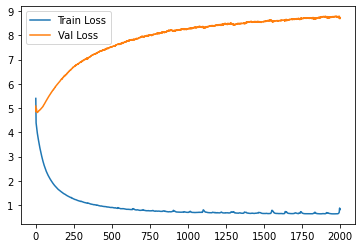

In [17]:
plt.plot(his.history['loss'], label='Train Loss')
plt.plot(his.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

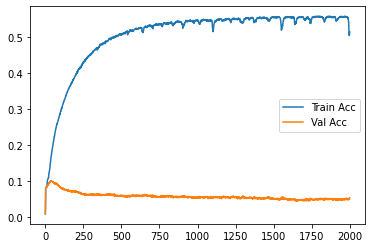

In [18]:
plt.plot(his.history['accuracy'], label='Train Acc')
plt.plot(his.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

Accuracy is not best metric coz, for eg word after "The" can be more than one words and no any one word specificially.

Encoder Done

---

#### Sampling Model

In [0]:
# Maing use of same trained layer
input2 = Input((1, ))
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

In [23]:
sampling_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             150000      input_4[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25)           0                                            
____________________________________________________________________________________________

In [0]:
idx2word = {v:k for k, v in word2idx.items()} # reverse index

In [0]:
def sample_line():
  '''This will generate one line of the poem'''
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  eos = word2idx['<eos>']

  output_sequence = []

  for _ in range(max_seq_len):
    o, h, c = sampling_model.predict([np_input, h, c])

    probs = o[0,0]
    if np.argmax(probs) == 0:
      print('▬▬▬') #WTF
    probs[0] = 0
    probs /= probs.sum()

    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    output_sequence.append(idx2word.get(idx, f'<WTF {idx}>'))

    np_input[0,0] = idx

  return ' '.join(output_sequence)

In [36]:
# Generate 4 lines for 10 times
for _ in range(10):
  for i in range(4):
    print(sample_line())

  print('-'*50)

on an ice cake.
another from the bedroom to the attic,
'then i don't know. it must be strange enough.
until i'd had him worn to skin and bones,
--------------------------------------------------
by flying like a bird (silent in flight,
i never tended when all us- - '
to bring me to where it settled whose i be,
great monolithic knees the former town
--------------------------------------------------
could tell you why he ever cared himself-
and built a man, but like en milk a bat
the minute they heard my step went till it should nothing. listen.
they've got it settled wrong, and i can prove it.
--------------------------------------------------
there wasn't always hudson's bay
unfortunately here, you treat your guide with due respect
'strangely, it's anything all against the cliff a waterfall.
does it purport to speak in? not old grandsir's
--------------------------------------------------
as if for fear of treading upon me.
and if i'd left him hitched unblanketed
i pushed myself upsta